In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Two Grid Correction

Before we do multigrid, we can understand the basic flow by using 2 grids: a fine and coarse grid.

We want to solve:

$$\nabla^2 \phi = f$$

with suitable boundary conditions.  Imagine that we have a approximate solution, $\tilde{\phi}$, then we can define the error with respect to the true solution, $\phi^{\mathrm{true}}$ as:

$$e = \phi^{\mathrm{true}} - \tilde{\phi}$$

Our Poisson equation is linear, so we can apply the $\nabla^2$ operator to our error:

$$\nabla^2 e = \nabla^2 \phi^{\mathrm{true}} - \nabla^2 \tilde{\phi} = f - \nabla^2 \tilde{\phi}$$

This since $\tilde{\phi}$ is just our approximation to $\phi^{\mathrm{true}}$, this is just the residual, so:

$$\nabla^2 e = r$$

Notice that this is the same type of equation as our original equation.  But the boundary conditions are now homogeneous (of the same type as the original) regardless of whether they were inhomogeneous or homogeneous originally.  For example:

* If the BCs were inhomogenous Dirichlet, $\phi(a) = A$, then 

  $$e(a) = \phi^{\mathrm{true}}(a) - \tilde{\phi}(a) = 0$$
  
  since both the true solution and our approximation satisfy the same boundary conditions.
  
* Likewise, if the BCs were inhomogenous Neumann, $\phi^\prime(a) = C$, then

  $$e^{\prime}(a) = \phi^{\mathrm{true},\prime}(a) - \tilde{\phi}^{\prime}(a) = 0$$

The key idea in multigrid is that long wavelength errors take longer to smooth away.  But long wavelength errors look shorter wavelength on a coarser grid.  This suggests that we smooth a bit on a fine grid to get rid of the short wavelength errors and then transfer down to a coarser grid, and smooth the error equation there, and then bring the error back to the fine grid to correct the fine grid solution.

We'll use the superscript $h$ to represent the fine grid and the superscript $2h$ to represent a grid that is coarser by a factor of 2.

Here's the basic flow:

<div style="border: solid; padding: 10px; width: 80%; margin: 0 auto; background: #dddddd">
    
* Smooth for $N_\mathrm{smooth}$ iterations on the fine grid, solving $\nabla^2 \phi = f$ to get an approximation $\tilde{\phi}$

* Compute the residual, on the fine grid:

  $$r^h = f - \nabla^2 \tilde{\phi}$$
  
* Restrict $r^h$ to the coarse grid:

  $$r^{2h} \leftarrow r^h$$
  
* Solve the error equation on the coarse grid:

  $$\nabla^2 e^{2h} = r^{2h}$$
  
* Prolong the error from the coarse grid up to the fine grid:

  $$e^{2h} \rightarrow e^{h}$$
  
* Correct the fine grid solution, since by the definition of $e$, $\phi^{\mathrm{true}} = \tilde{\phi} + e$

  $$\tilde{\phi}^h \leftarrow \tilde{\phi}^h + e^h$$
  
* This correction may have introduced some short wavelength noise (from the prolongation), so smooth $\nabla^2 \phi = f$ on the fine grid for $N_\mathrm{smooth}$ iterations.
</div>

For now, to solve the error equation, we'll resort to simply smoothing until all of residual is below our desired tolerance.  In a little bit though, we'll see that we can just do this procedure recursively for that step.

We'll start with a grid class that has storage for the solution, righthand side, and residual, and knows how to fill boundary conditions, prolong, and restrict the data, and all of the operations we implemented previously (restriction, prolongation, computing the residual, taking the norm).

We store the solution variable ($\phi$ or $e$) as `Grid.v` in this class.

In [2]:
import grid

In [3]:
%cat grid.py

import numpy as np

class Grid:
    def __init__(self, nx, ng=1, xmin=0, xmax=1,
                 bc_left_type="dirichlet", bc_left_val=0.0,
                 bc_right_type="dirichlet", bc_right_val=0.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        self.bc_left_type = bc_left_type
        self.bc_left_val = bc_left_val

        self.bc_right_type = bc_right_type
        self.bc_right_val = bc_right_val

        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

        # storage for the solution
        self.v = self.scratch_array()
        self.f = self.scratch_array()
        self.r = self.scratch_array()

    def scratch_array(self):
        """return a scratch array dimensioned for our grid """
      

We also need the `relax` function we wrote previously.  Here we just paste it below:

In [13]:
class TooManyIterations(Exception):
    pass

def relax(g, tol=1.e-8, max_iters=200000):
    
    iter = 0
    fnorm = g.source_norm()
    if fnorm == 0.0:
        fnorm = tol
        
    r = g.residual_norm()
    
    if tol is None:
        test = iter < max_iters
    else:
        test = iter < max_iters and r > tol * fnorm

    g.fill_bcs()

    while test:
        g.v[g.ilo:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.f[g.ilo:g.ihi+1:2] +
                                        g.v[g.ilo+1:g.ihi+2:2] + g.v[g.ilo-1:g.ihi:2])
    
        g.fill_bcs()

        g.v[g.ilo+1:g.ihi+1:2] = 0.5 * (-g.dx * g.dx * g.f[g.ilo+1:g.ihi+1:2] +
                                          g.v[g.ilo+2:g.ihi+2:2] + g.v[g.ilo:g.ihi:2])
        
        g.fill_bcs()
        
        r = g.residual_norm()
        
        iter += 1
        
        if tol is None:
            test = iter < max_iters
        else:
            test = iter < max_iters and r > tol * fnorm

    if tol is not None and iter >= max_iters:
        raise TooManyIterations(f"too many iterations, niter = {iter}")

Now we can write our two-grid solver.  We'll solve the same system as before:

$$\phi^{\prime\prime} = \sin(x)$$

on $[0, 1]$ with homogeneous Dirichlet BCs.

In [14]:
def analytic(x):
    return -np.sin(x) + x * np.sin(1.0)

def f(x):
    return np.sin(x)

In [16]:
nx = 128
n_smooth = 10

# create the grids
fine = grid.Grid(nx)
coarse = grid.Grid(nx//2)

# initialize the RHS
fine.f[:] = f(fine.x)

# smooth on the fine grid
relax(fine, max_iters=n_smooth, tol=None)

# compute the residual
fine.compute_residual()

# restrict the residual down to the coarse grid as the coarse rhs
coarse.f[:] = fine.restrict("r")

# solve the coarse problem:
relax(coarse, tol=1.e-8)

# prolong the error up from the coarse grid and correct the fine grid solution
fine.v += coarse.prolong("v")

# smooth on the fine grid
relax(fine, max_iters=n_smooth, tol=None)

Let's look at the solution:

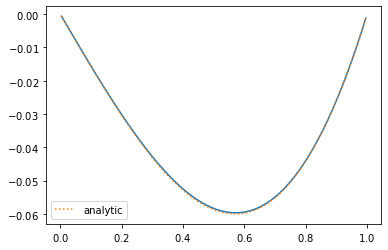

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(fine.x[fine.ilo:fine.ihi+1], fine.v[fine.ilo:fine.ihi+1])
ax.plot(fine.x[fine.ilo:fine.ihi+1], analytic(fine.x[fine.ilo:fine.ihi+1]), label="analytic", ls=":")
ax.legend()